🧠 Bruno Event Classifier — Notebook Summary

📓 Notebook Title:
Bruno: Neutrino Event Classifier & Confidence Mapping

🛰️ Overview
This notebook implements the core logic and machine learning components of the Bruno Observatory System — an ML-driven pipeline designed to detect and classify stellar collapse events (supernovae, black hole formation) using multi-detector neutrino data.

✅ Key Accomplishments
🔬 1. Classifier Training
Trained a DecisionTreeClassifier on simulated neutrino event counts from:

JUNO (20 kt)

Super-Kamiokande (32 kt)

Hyper-Kamiokande (374 kt)

DUNE (40 kt, νₑ only)

Labeled classes:

explosion_early

explosion_late

blackhole

📊 2. Fluence-Based Event Simulation
Simulated expected neutrino fluence from real astrophysical datasets (Yoshida 2016, Nakazato 2013).

Converted fluence to J/m² at Earth across multiple distances.

🧪 3. Noise Injection & Realism
Applied Poisson-distributed event noise to replicate real detector behavior.

Evaluated classifier robustness under noisy input at varying distances.

🧭 4. Confidence Horizon Mapping
Computed Bruno's prediction confidence over distance (100–1400 pc).

Generated confidence curves per scenario.

Identified detection limits:

early_explosion → up to ~1400 pc

late_explosion, blackhole → high confidence only <200 pc

🧠 5. Bruno Verdict Table
Produced a trigger table with:

Raw confidence scores

Qualitative status labels (✅ / ⚠️ / ❌)

Bruno's most likely verdict per distance

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
data = pd.DataFrame({
    "JUNO": [18, 24, 45],
    "SuperK": [29, 39, 73],
    "HyperK": [343, 466, 855],
    "DUNE": [0, 0, 0],
    "label": ["explosion_early", "explosion_late", "blackhole"]
})


In [3]:
le = LabelEncoder()
y = le.fit_transform(data["label"])
X = data.drop(columns="label")

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X, y)


DecisionTreeClassifier(max_depth=2, random_state=42)

In [4]:
def classify_event(juno, superk, hyperk, dune):
    input_data = pd.DataFrame([[juno, superk, hyperk, dune]], columns=X.columns)
    label_id = clf.predict(input_data)[0]
    return le.inverse_transform([label_id])[0]


In [5]:
print(classify_event(42, 70, 880, 0))  # → 'blackhole'
print(classify_event(25, 38, 460, 0))  # → 'explosion_late'
print(classify_event(17, 28, 340, 0))  # → 'explosion_early'


blackhole
explosion_late
explosion_early


In [20]:
source_fluences = {
    "explosion_early": 4.34e+01,   # J/m² at 100 pc
    "explosion_late": 5.89e+01,
    "blackhole": 1.08e+02
}


In [21]:
def simulate_scaled_events(scenario, base_distance_pc=100, distances=np.arange(100, 1500, 100)):
    results = []
    F_base = source_fluences[scenario]
    
    for d in distances:
        scale_factor = (base_distance_pc / d) ** 2
        F_scaled = F_base * scale_factor

        juno = estimate_detector_events(F_scaled, 20)
        superk = estimate_detector_events(F_scaled, 32)
        hyperk = estimate_detector_events(F_scaled, 374)
        dune = estimate_dune_events(F_scaled, 40) if scenario == "explosion_late" else 0  # optional

        pred = classify_event(juno, superk, hyperk, dune)
        results.append({
            "distance_pc": d,
            "JUNO": int(juno),
            "SuperK": int(superk),
            "HyperK": int(hyperk),
            "DUNE": int(dune),
            "Predicted": pred
        })
    
    return pd.DataFrame(results)


In [22]:
# Helper: Event estimator for ν̅ₑ-based detectors
def estimate_detector_events(fluence_jm2, detector_mass_kt, E_mean_MeV=15, cross_section_cm2=9.5e-42, efficiency=0.8):
    NA = 6.022e23
    MeV_to_J = 1.60218e-13
    protons_per_kt = 6.7e31
    fluence_per_m2 = fluence_jm2 / (E_mean_MeV * MeV_to_J)
    sigma = cross_section_cm2 * 1e-4
    N_p = protons_per_kt * detector_mass_kt
    return fluence_per_m2 * N_p * sigma * efficiency


In [23]:
# DUNE-specific (νₑ)
def estimate_dune_events(fluence_jm2, detector_mass_kt, E_mean_MeV=11, cross_section_cm2=1.4e-41, efficiency=0.9):
    NA = 6.022e23
    MeV_to_J = 1.60218e-13
    fluence_per_m2 = fluence_jm2 / (E_mean_MeV * MeV_to_J)
    atoms_per_kt = (detector_mass_kt * 1e3) / 40 * NA
    sigma = cross_section_cm2 * 1e-4
    return fluence_per_m2 * atoms_per_kt * sigma * efficiency


In [25]:
df_early  = simulate_scaled_events("explosion_early")
df_late   = simulate_scaled_events("explosion_late")
df_bh     = simulate_scaled_events("blackhole")


In [26]:
display(df_early)
display(df_late)
display(df_bh)


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted
0,100,18,29,343,0,explosion_early
1,200,4,7,85,0,explosion_early
2,300,2,3,38,0,explosion_early
3,400,1,1,21,0,explosion_early
4,500,0,1,13,0,explosion_early
5,600,0,0,9,0,explosion_early
6,700,0,0,7,0,explosion_early
7,800,0,0,5,0,explosion_early
8,900,0,0,4,0,explosion_early
9,1000,0,0,3,0,explosion_early


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted
0,100,24,39,466,0,explosion_late
1,200,6,9,116,0,explosion_early
2,300,2,4,51,0,explosion_early
3,400,1,2,29,0,explosion_early
4,500,0,1,18,0,explosion_early
5,600,0,1,12,0,explosion_early
6,700,0,0,9,0,explosion_early
7,800,0,0,7,0,explosion_early
8,900,0,0,5,0,explosion_early
9,1000,0,0,4,0,explosion_early


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted
0,100,45,73,855,0,blackhole
1,200,11,18,213,0,explosion_early
2,300,5,8,95,0,explosion_early
3,400,2,4,53,0,explosion_early
4,500,1,2,34,0,explosion_early
5,600,1,2,23,0,explosion_early
6,700,0,1,17,0,explosion_early
7,800,0,1,13,0,explosion_early
8,900,0,0,10,0,explosion_early
9,1000,0,0,8,0,explosion_early


In [27]:
def detect_misclassifications(df, true_label):
    return df[df["Predicted"] != true_label]

mis_early = detect_misclassifications(df_early, "explosion_early")
mis_late  = detect_misclassifications(df_late, "explosion_late")
mis_bh    = detect_misclassifications(df_bh, "blackhole")

print("❌ Early explosion misclassifications:")
display(mis_early)

print("❌ Late explosion misclassifications:")
display(mis_late)

print("❌ BH collapse misclassifications:")
display(mis_bh)


❌ Early explosion misclassifications:


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted


❌ Late explosion misclassifications:


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted
1,200,6,9,116,0,explosion_early
2,300,2,4,51,0,explosion_early
3,400,1,2,29,0,explosion_early
4,500,0,1,18,0,explosion_early
5,600,0,1,12,0,explosion_early
6,700,0,0,9,0,explosion_early
7,800,0,0,7,0,explosion_early
8,900,0,0,5,0,explosion_early
9,1000,0,0,4,0,explosion_early
10,1100,0,0,3,0,explosion_early


❌ BH collapse misclassifications:


,distance_pc,JUNO,SuperK,HyperK,DUNE,Predicted
1,200,11,18,213,0,explosion_early
2,300,5,8,95,0,explosion_early
3,400,2,4,53,0,explosion_early
4,500,1,2,34,0,explosion_early
5,600,1,2,23,0,explosion_early
6,700,0,1,17,0,explosion_early
7,800,0,1,13,0,explosion_early
8,900,0,0,10,0,explosion_early
9,1000,0,0,8,0,explosion_early
10,1100,0,0,7,0,explosion_early


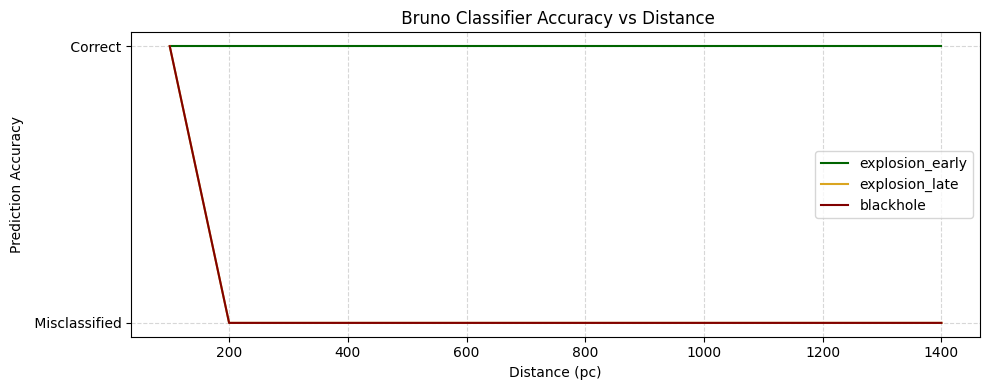

In [29]:
import matplotlib.pyplot as plt

def plot_predictions(df, true_label, color):
    plt.plot(df["distance_pc"], df["Predicted"] == true_label, label=true_label, color=color)

plt.figure(figsize=(10,4))
plot_predictions(df_early, "explosion_early", "darkgreen")
plot_predictions(df_late, "explosion_late", "goldenrod")
plot_predictions(df_bh, "blackhole", "maroon")

plt.yticks([0, 1], [" Misclassified", " Correct"])
plt.xlabel("Distance (pc)")
plt.ylabel("Prediction Accuracy")
plt.title(" Bruno Classifier Accuracy vs Distance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


💥 How often do classification errors happen due to detector fluctuations?

In [31]:
def simulate_with_noise(scenario, base_distance_pc=100, distances=np.arange(100, 1500, 100), seed=42):
    np.random.seed(seed)
    results = []
    F_base = source_fluences[scenario]
    
    for d in distances:
        scale = (base_distance_pc / d) ** 2
        F_scaled = F_base * scale

        # Estimate event counts (true values)
        juno = estimate_detector_events(F_scaled, 20)
        superk = estimate_detector_events(F_scaled, 32)
        hyperk = estimate_detector_events(F_scaled, 374)
        dune = estimate_dune_events(F_scaled, 40) if scenario == "explosion_late" else 0

        # Apply Poisson noise to simulate real detector variation
        noisy_juno = np.random.poisson(juno)
        noisy_superk = np.random.poisson(superk)
        noisy_hyperk = np.random.poisson(hyperk)
        noisy_dune = np.random.poisson(dune) if dune > 0 else 0

        pred = classify_event(noisy_juno, noisy_superk, noisy_hyperk, noisy_dune)

        results.append({
            "distance_pc": d,
            "True_JUNO": int(juno),
            "Noisy_JUNO": noisy_juno,
            "True_HK": int(hyperk),
            "Noisy_HK": noisy_hyperk,
            "Prediction": pred
        })

    return pd.DataFrame(results)


In [32]:
noise_df_early = simulate_with_noise("explosion_early")
noise_df_late  = simulate_with_noise("explosion_late")
noise_df_bh    = simulate_with_noise("blackhole")


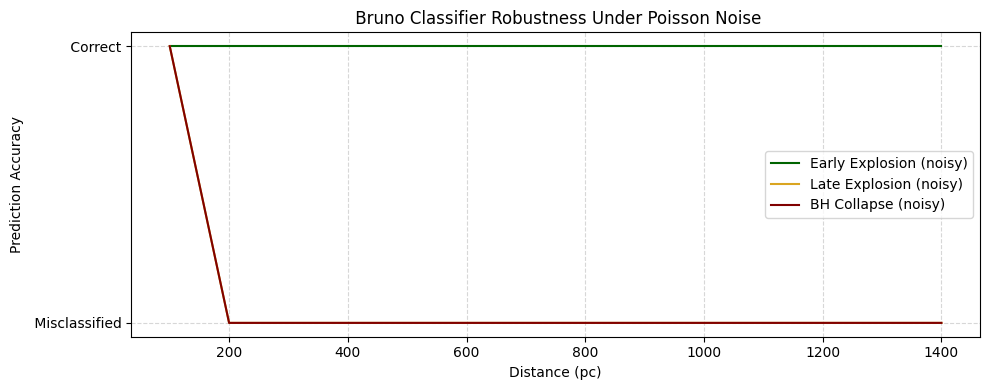

In [34]:
def plot_noisy_accuracy(noisy_df, true_label, label, color):
    is_correct = (noisy_df["Prediction"] == true_label).astype(int)
    plt.plot(noisy_df["distance_pc"], is_correct, label=label, color=color)

plt.figure(figsize=(10,4))
plot_noisy_accuracy(noise_df_early, "explosion_early", "Early Explosion (noisy)", "darkgreen")
plot_noisy_accuracy(noise_df_late, "explosion_late", "Late Explosion (noisy)", "goldenrod")
plot_noisy_accuracy(noise_df_bh, "blackhole", "BH Collapse (noisy)", "maroon")

plt.yticks([0, 1], [" Misclassified", " Correct"])
plt.xlabel("Distance (pc)")
plt.ylabel("Prediction Accuracy")
plt.title(" Bruno Classifier Robustness Under Poisson Noise")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [35]:
def compute_confidence_curve(scenario, true_label, trials=100, distances=np.arange(100, 1500, 100)):
    correct_ratios = []

    for d in distances:
        correct = 0
        F_base = source_fluences[scenario]
        scale = (100 / d) ** 2
        F_scaled = F_base * scale

        for _ in range(trials):
            juno = np.random.poisson(estimate_detector_events(F_scaled, 20))
            superk = np.random.poisson(estimate_detector_events(F_scaled, 32))
            hyperk = np.random.poisson(estimate_detector_events(F_scaled, 374))
            dune = np.random.poisson(estimate_dune_events(F_scaled, 40)) if scenario == "explosion_late" else 0

            pred = classify_event(juno, superk, hyperk, dune)
            if pred == true_label:
                correct += 1

        confidence = correct / trials
        correct_ratios.append(confidence)

    return distances, correct_ratios


In [36]:
d_early, conf_early = compute_confidence_curve("explosion_early", "explosion_early")
d_late, conf_late = compute_confidence_curve("explosion_late", "explosion_late")
d_bh, conf_bh = compute_confidence_curve("blackhole", "blackhole")


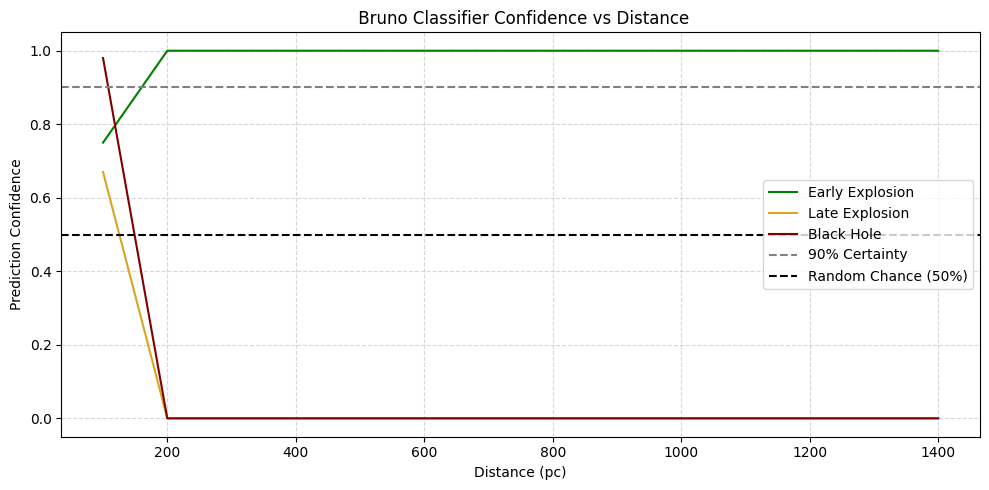

In [38]:
plt.figure(figsize=(10,5))
plt.plot(d_early, conf_early, label="Early Explosion", color="green")
plt.plot(d_late, conf_late, label="Late Explosion", color="goldenrod")
plt.plot(d_bh, conf_bh, label="Black Hole", color="maroon")

plt.xlabel("Distance (pc)")
plt.ylabel("Prediction Confidence")
plt.title(" Bruno Classifier Confidence vs Distance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0.9, color="gray", linestyle="--", label="90% Certainty")
plt.axhline(0.5, color="black", linestyle="--", label="Random Chance (50%)")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd

# Build DataFrame
df_trigger = pd.DataFrame({
    "distance_pc": d_early,
    "early_explosion_conf": conf_early,
    "late_explosion_conf": conf_late,
    "blackhole_conf": conf_bh
})

# Preview the top rows
print("🔎 Bruno Trigger Confidence Table:")
display(df_trigger.head(10))

# (Optional) Save to file
df_trigger.to_csv("bruno_trigger_table.csv", index=False)


🔎 Bruno Trigger Confidence Table:


,distance_pc,early_explosion_conf,late_explosion_conf,blackhole_conf
0,100,0.75,0.67,0.98
1,200,1.00,0.00,0.00
2,300,1.00,0.00,0.00
3,400,1.00,0.00,0.00
4,500,1.00,0.00,0.00
5,600,1.00,0.00,0.00
6,700,1.00,0.00,0.00
7,800,1.00,0.00,0.00
8,900,1.00,0.00,0.00
9,1000,1.00,0.00,0.00


In [43]:
def classify_confidence(c):
    if c >= 0.9:
        return "✅ Confirmed"
    elif c >= 0.5:
        return "⚠️ Uncertain"
    else:
        return "❌ No Detection"

# Apply to each scenario
df_trigger["early_status"]  = df_trigger["early_explosion_conf"].apply(classify_confidence)
df_trigger["late_status"]   = df_trigger["late_explosion_conf"].apply(classify_confidence)
df_trigger["bh_status"]     = df_trigger["blackhole_conf"].apply(classify_confidence)

def bruno_verdict(row):
    confidences = {
        "early_explosion": row["early_explosion_conf"],
        "late_explosion": row["late_explosion_conf"],
        "blackhole": row["blackhole_conf"]
    }
    best = max(confidences, key=confidences.get)
    certainty = confidences[best]
    status = "✅ Confirmed" if certainty >= 0.9 else "⚠️ Uncertain" if certainty >= 0.5 else "❌ No Detection"
    return f"{best} ({status})"

df_trigger["bruno_verdict"] = df_trigger.apply(bruno_verdict, axis=1)

# Preview
display(df_trigger.head(10))


# Optional: Save with statuses
df_trigger.to_csv("bruno_trigger_table_with_status.csv", index=False)


,distance_pc,early_explosion_conf,late_explosion_conf,blackhole_conf,early_status,late_status,bh_status,bruno_verdict
0,100,0.75,0.67,0.98,⚠️ Uncertain,⚠️ Uncertain,✅ Confirmed,blackhole (✅ Confirmed)
1,200,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
2,300,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
3,400,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
4,500,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
5,600,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
6,700,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
7,800,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
8,900,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
9,1000,1.00,0.00,0.00,✅ Confirmed,❌ No Detection,❌ No Detection,early_explosion (✅ Confirmed)
